In [1]:
import os
import sys
from pathlib import Path

current_dir = os.getcwd()
file = Path(current_dir).resolve()
sys.path.append(str(file.parents[0]))
sys.path.append(str(file.parents[1]))
sys.path.append(str(file.parents[2]))
base_dir = Path(current_dir).resolve().parents[0]
src_path = base_dir / 'src'

In [2]:
import torch
import TPTBox
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
from TPTBox import NII
from monai.transforms import ResizeWithPadOrCrop, CastToType
from torch import nn
from utils.brats_tools import get_central_slice, plot_slices, preprocess
from src.pl_unet import LitUNetModule

# load model checkpoint
checkpoint_path = '/home/student/farid_ma/dev/multiclass_softseg/MulticlassSoftSeg/src/logs/lightning_logs/3D_UNet/3D_UNet_v6_lr0.0001_batch_size_1_n_epochs_80_dimUNet_16_binary:False_with_augmentations/checkpoints/epoch=79-step=70000.ckpt'

# choose base path for image and segmentation mask
base_path = '/home/student/farid_ma/dev/multiclass_softseg/MulticlassSoftSeg/data/external/ASNR-MICCAI-BraTS2023-GLI-Challenge/val/BraTS-GLI-00071-000/BraTS-GLI-00071-000-'

model_input_size = [200,200,152]
og_img_size = [240,240,155]

pad = ResizeWithPadOrCrop(og_img_size)
crop = ResizeWithPadOrCrop(model_input_size)

softmax = nn.Softmax(dim=1)

### Loading Model Checkpoint

In [5]:
# try if torch.load works, otherwise raise an error and exit
try:
    checkpoint = torch.load(checkpoint_path)
except Exception as e:
    print(f"Error: Invalid checkpoint path or file not found: {checkpoint_path}")
    sys.exit(1)

# load trained model
model = LitUNetModule.load_from_checkpoint(checkpoint_path)
model.eval()

LitUNetModule(
  (model): Unet3D(
    (init_conv): Conv3d(1, 16, kernel_size=(7, 7, 7), stride=(1, 1, 1), padding=(3, 3, 3))
    (downs): ModuleList(
      (0): ModuleList(
        (0-1): 2 x ResnetBlock3D(
          (block1): Block3D(
            (proj): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
            (norm): GroupNorm(8, 16, eps=1e-05, affine=True)
            (act): LeakyReLU(negative_slope=0.01)
          )
          (block2): Block3D(
            (proj): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
            (norm): GroupNorm(8, 16, eps=1e-05, affine=True)
            (act): LeakyReLU(negative_slope=0.01)
          )
          (res_conv): Identity()
        )
        (2): Conv3d(16, 16, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1))
      )
      (1): ModuleList(
        (0): ResnetBlock3D(
          (block1): Block3D(
            (proj): Conv3d(16, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padd

### Loading Nifti Image and Segmentation Mask

In [6]:
# extending base path with endings for image and segmentation mask
img_path = base_path + 't2f.nii.gz'
seg_path = base_path + 'seg.nii.gz'

# load mri image and segmentation mask i.e. ground truth
try: 
    img = NII.load(img_path, seg=False)
    seg = NII.load(seg_path, seg=True)

except Exception as e:
    print(f"Error: Invalid image or segmentation path: {img_path} or {seg_path}")
    sys.exit(1)

# get numpy array from image and segmentation mask
img_array = img.get_array()
seg_array = seg.get_array()

img_slice = get_central_slice(img_array)
seg_slice = get_central_slice(seg_array)

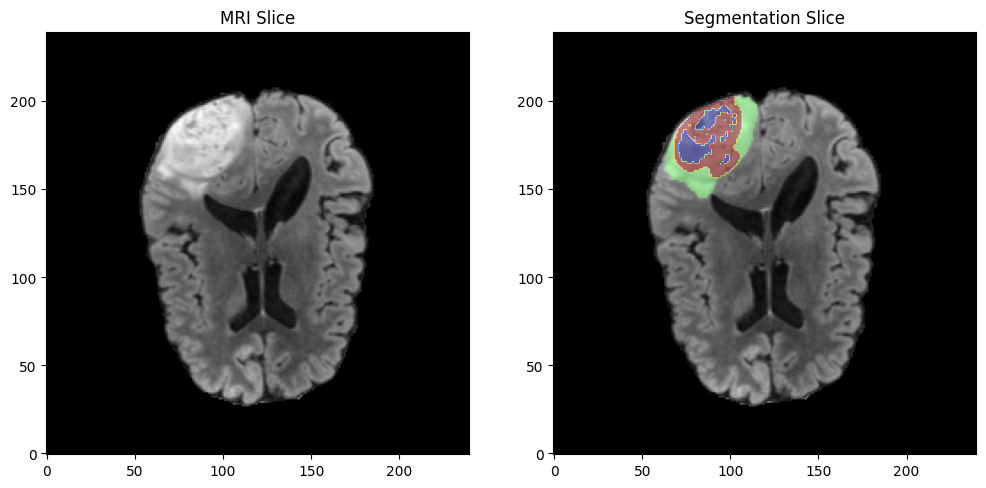

In [7]:
# label 1: NCR (necrotic tumor core) -> blue, label 2: ED (edematous tissue) -> green, label 3: ET (enhancing tumor) -> red 
plot_slices(img_slice, seg_slice, '')

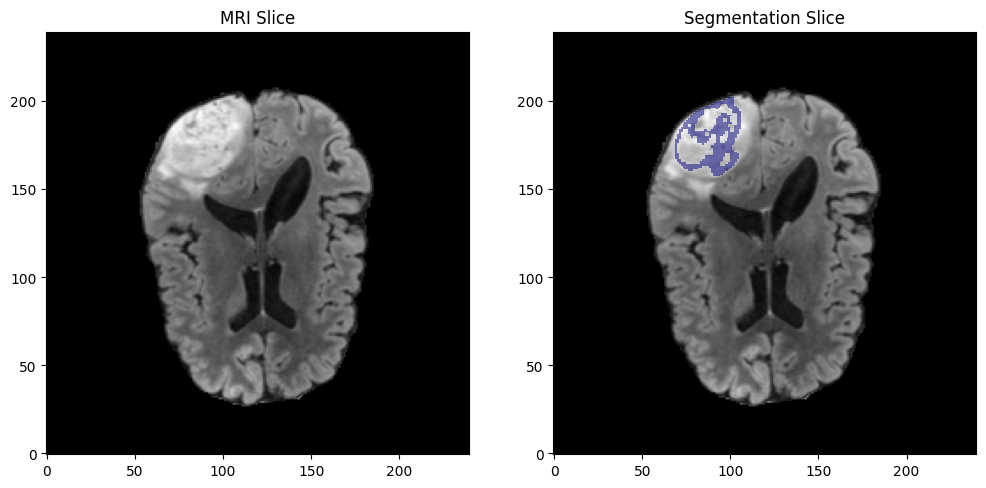

In [8]:
# Enhancing Tumor
plot_slices(img_slice, (seg_slice==3), '')

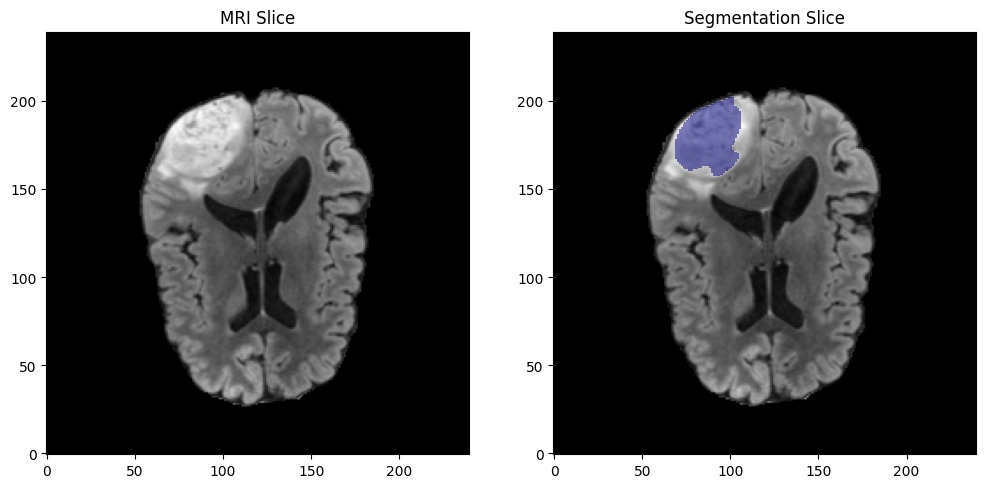

In [9]:
# Tumor Core
plot_slices(img_slice, ((seg_slice==1) | (seg_slice==3)), '')

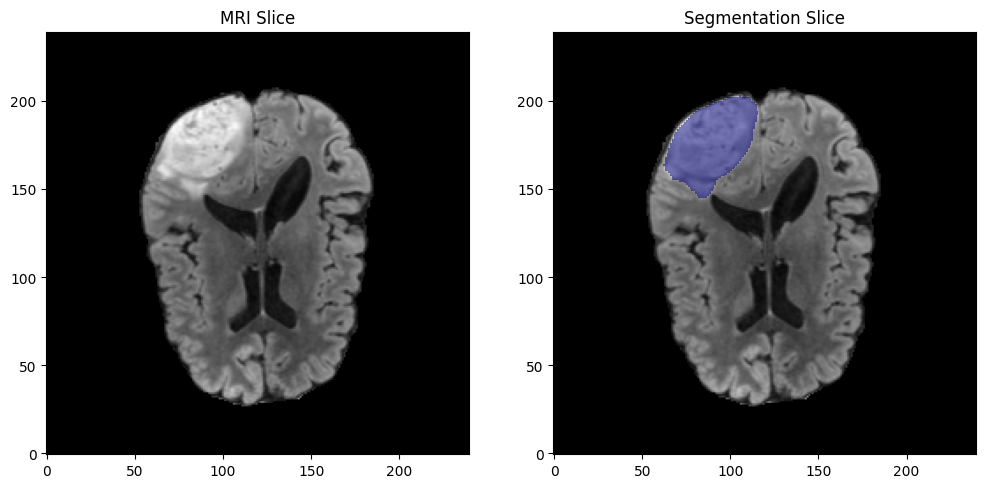

In [10]:
# Whole Tumor
plot_slices(img_slice, (seg_slice>0), '')

### Getting prediction from model

In [7]:
from monai.transforms import ResizeWithPadOrCrop, CastToType
from utils.brats_tools import preprocess
from torch import nn

In [11]:
img_tensor = preprocess(img_array, False, False)

#transform = CastToType(dtype=torch.float)
crop = ResizeWithPadOrCrop([200,200,152])

#img_tensor = transform(img_tensor)
img_tensor = crop(img_tensor)
img_tensor = img_tensor.unsqueeze(0)
img_tensor = img_tensor.to(next(model.parameters()).device) 

print(img_tensor.shape)

torch.Size([1, 1, 200, 200, 152])


In [12]:
with torch.no_grad():
    logits = model(img_tensor)

In [13]:
print(logits.shape)
print(seg.shape)

torch.Size([1, 4, 200, 200, 152])
(240, 240, 155)


In [14]:
print("Current tensor shape:", img_tensor.shape)

Current tensor shape: torch.Size([1, 1, 200, 200, 152])


In [15]:
softmax = nn.Softmax(dim=1)

with torch.no_grad():
    probs = softmax(logits)    # applying softmax to the logits to get probabilites
    preds = torch.argmax(probs, dim=1)   # getting the class with the highest probability
    preds_cpu = preds.cpu()
    del logits, probs, preds

In [16]:
print(preds_cpu.shape)
print(f"preds_cpu dtype: {preds_cpu.dtype}")
preds_cpu = preds_cpu.type(torch.float16)

torch.Size([1, 200, 200, 152])
preds_cpu dtype: torch.int64


In [17]:
pad = ResizeWithPadOrCrop([240,240,155])
preds_pad = pad(preds_cpu)
print(preds_pad.shape)
preds_pad = preds_pad.squeeze(0)
print(preds_pad.shape)

torch.Size([1, 240, 240, 155])
torch.Size([240, 240, 155])


In [18]:
preds_np = preds_pad.numpy()
pred_slice = get_central_slice(preds_np)
print(pred_slice.shape)
print(img_slice.shape)

(240, 240)
(240, 240)


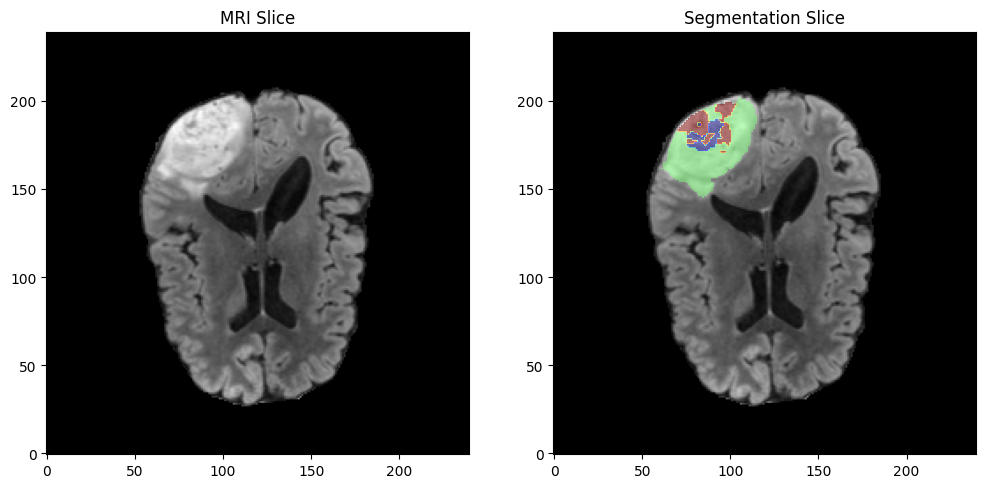

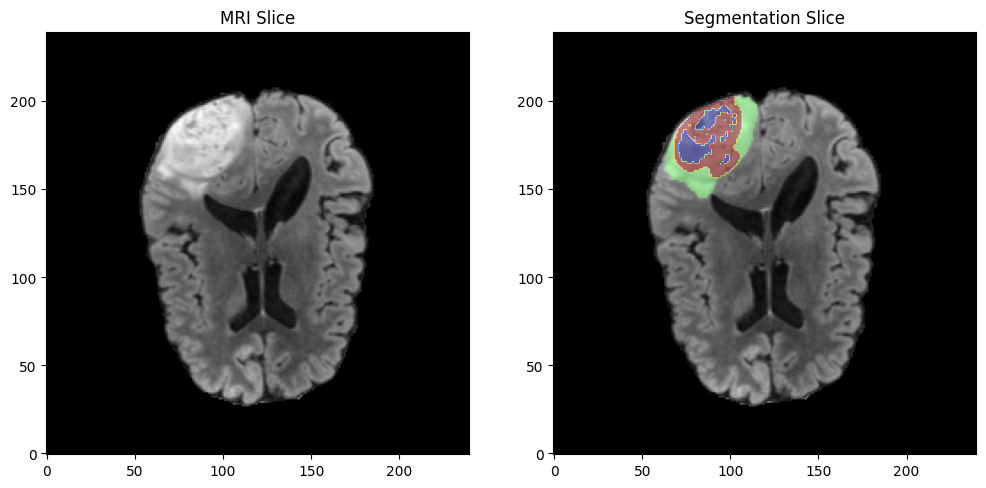

In [19]:
plot_slices(img_slice, pred_slice, '')
plot_slices(img_slice, seg_slice, '')